 # Task

## どのような問題が解決できるか

がん、心臓病、慢性閉塞性肺疾患、アルツハイマー病、糖尿病などの疾患の核の検出自動化のアルゴリズム作成のタスクです。

このようなアルゴリズムが実装され、核検出を自動化が可能になることで、まれな疾患からインフルエンザまで、疾患の早期発見と早期治療実現が期待できます。
  
  また、日本では一つの薬が世に出るまでには、優に10年を超える月日と、何百億円という莫大な費用がかかるといわれていますが、核を特定することで、より効率的な薬物検査が可能になり、各新薬が発売されるまでの期間短縮と開発費削減が期待できます。
   
   >https://www.kaggle.com/c/data-science-bowl-2018
   >https://www.epmate.co.jp/clear/period/


## セグメンテーションとは

領域分割と訳され、画像データのピクセルごとにラベルを予測する手法。形状や面積といった情報が得られるため、応用先も多く、活発に研究されている。
セグメンテーションにはさらに二つの手法がある。
- Semantic Segmentation  
  - 各ピクセルにクラスのラベルを付与する問題。 
  - ボトルが4本ある場合でも全て「ボトルクラス」のラベルをつける
- Instance Segmentation  
   - 個々の物体ごとにベルのラベルを付与する問題。
   - ボトルが4本ある場合、別々のラベルを付与する

## 評価関数
>https://meideru.com/archives/3538

IoU(intersection over union)は、異なる閾値における平均平均精度(mean average precision)。複数の画像の重なりの割合を表す値。

$IoU(A,B) = \frac{A \cap B}{ A \cup B}.$

閾値は、0.5〜0.95（0.5,0.5,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95）の範囲で0.5づつステップいく。 言い換えれば、0.5の閾値では、予測オブジェクトは、地面真理オブジェクトとの結合上の交差が0.5より大きい場合、「ヒット」と見なされます。

各閾値tにおいて、正確な値は、予測対象をすべてのグランドトゥルースオブジェクトと比較することから得られる真陽性（TP）、偽陰性（FN）、および偽陽性（FP）の数に基づいて計算される。
上記の式に
$ A = TP(t) + FP(t) ,B = TP(t) + FN(t)$  を代入して


$\frac{TP(t)}{TP(t) + FP(t) + FN(t)}.$

真陽性は、単一の予測されたオブジェクトが閾値を超えるIoUを有する地面真理オブジェクトと一致する場合にカウントされる。
偽陽性とは、予測されたオブジェクトに関連するグランドトゥルースオブジェクトがないことを示します。 偽陰性は、地面真理オブジェクトに関連付けられた予測オブジェクトがないことを示します。
次いで、単一の画像の平均精度が、各IoU閾値で上記の精度値の平均として計算される。

$\frac{1}{|thresholds|} \sum_t \frac{TP(t)}{TP(t) + FP(t) + FN(t)}.$

最後に、競合測定基準によって返されるスコアは、テストデータセット内の各画像の個々の平均精度を平均したものです。

# 完成例を確認する

①訓練データセット（stage1_trainから検証セットを差し引いたもの）を使用して、ImageNetウェイトから新しいモデルをトレーニング  
以下の条件で訓練を実行した。  
stage1_trainデータセット数 ：100  
検証データ：25

head:1epochあたりの訓練数 ９、epoch3  
full:1epochあたりの訓練数 ９、epoch4


# EDA

EDAカーネルを実行して分かったことを列挙する。

- 細胞核の画像とそのマスク（各細胞核の位置情報）が１つの訓練データとなる
- 画像サイズやカラーかグレースケールなどデータは様々な形式で存在する
- 画像サイズは256*256が最小で最も多く、最大サイズは1040*1388
- 細胞核の数は1-375
- ほぼピクセルレベルの細胞核画像もあるのでリサイズには注意する。

# 画像処理の基本をキャッチアップ
## グレースケール変換

In [69]:
import pathlib
import imageio
import numpy as np

# Glob the training data and load a single image path
training_paths = pathlib.Path('../input/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[3]
im = imageio.imread(str(im_path))

In [70]:
# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (256, 320, 4)
New image shape: (256, 320)


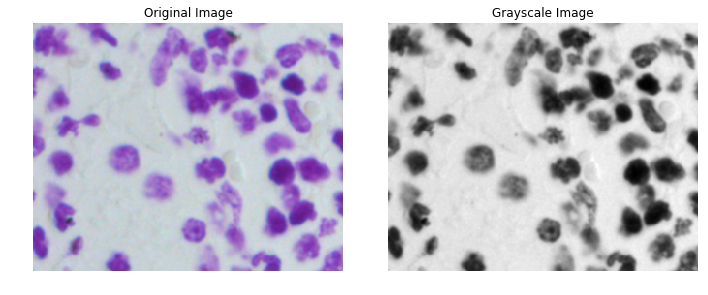

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

# Now, let's plot the data

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

## 背景削除

大津法によるシンプルな背景削除を行う。

In [101]:
import pathlib
import imageio
import numpy as np

# Glob the training data and load a single image path
training_paths = pathlib.Path('../input/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

Original image shape: (520, 696, 4)
New image shape: (520, 696)


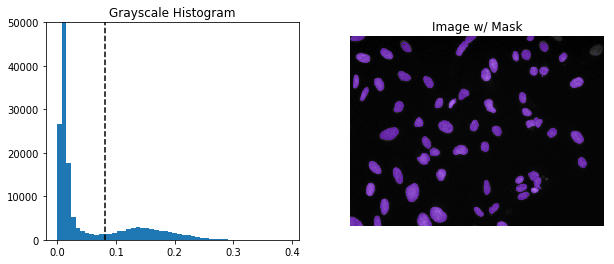

In [102]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

## 背景削除済み画像の核をランダムに色付けする

In [103]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


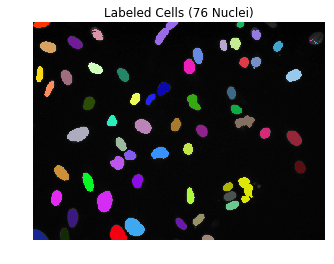

In [104]:
# Create a random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

In [105]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detected.


 ## 核ごとにマスクを作成する方法

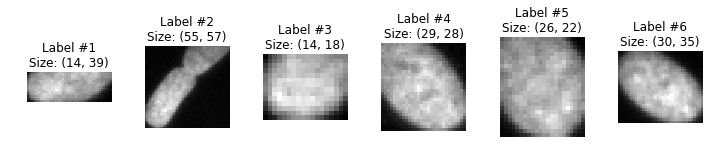

In [77]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

## 核が二つ重なった画像を分割する方法

In [78]:
# オブジェクトインデックスを取得し、バイナリオープンプロシージャを実行する
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

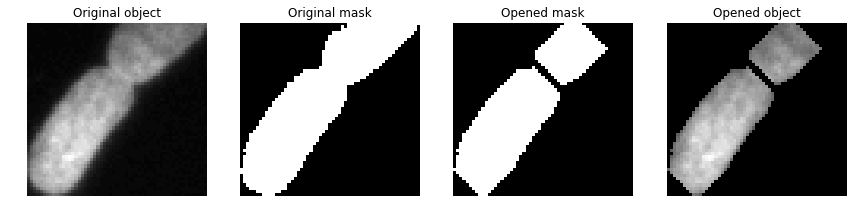

In [79]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

# PreProcessing

## 画像における、前処理の調査

In [162]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

# プロジェクトのRoot directory 　getcwd():作業ディレクトリ（カレントディレクトリ）を取得
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/nucleus"): #endswith():最後文字で終了する場合True
    # Go up two levels to the repo root　二つ階層を上がる
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))
    
# Mask RCNNをインポート
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

import nucleus

%matplotlib inline 
# Dataset directory
DATASET_DIR = ROOT_DIR #os.path.join(ROOT_DIR, "../../datasets/nucleus")

#nucleus.pyの設定を使用しますが、上書きします
#イメージのサイズ変更はここで実際のサイズを参照してください
class NoResizeConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "none"
    
config = NoResizeConfig()

In [163]:
import numpy as np
# データセットを呼び出す
dataset = nucleus.NucleusDataset()
'''サブセットは、stage1_train、stage1_test、...などのサブディレクトリの名前です。 
次の特別な値を使用することもできます。
train：stage1_trainを読み込みますが、検証画像は除外します
val：stage1_trainから検証画像を読み込みます。 検証イメージのリストについては、
nucleus.pyを参照してください。
'''
dataset.load_nucleus(DATASET_DIR, subset="train")
#データセットを使用する前に呼び出す必要があります
dataset.prepare()

##  Image Crops
### １画像から、４枚の画像を生成

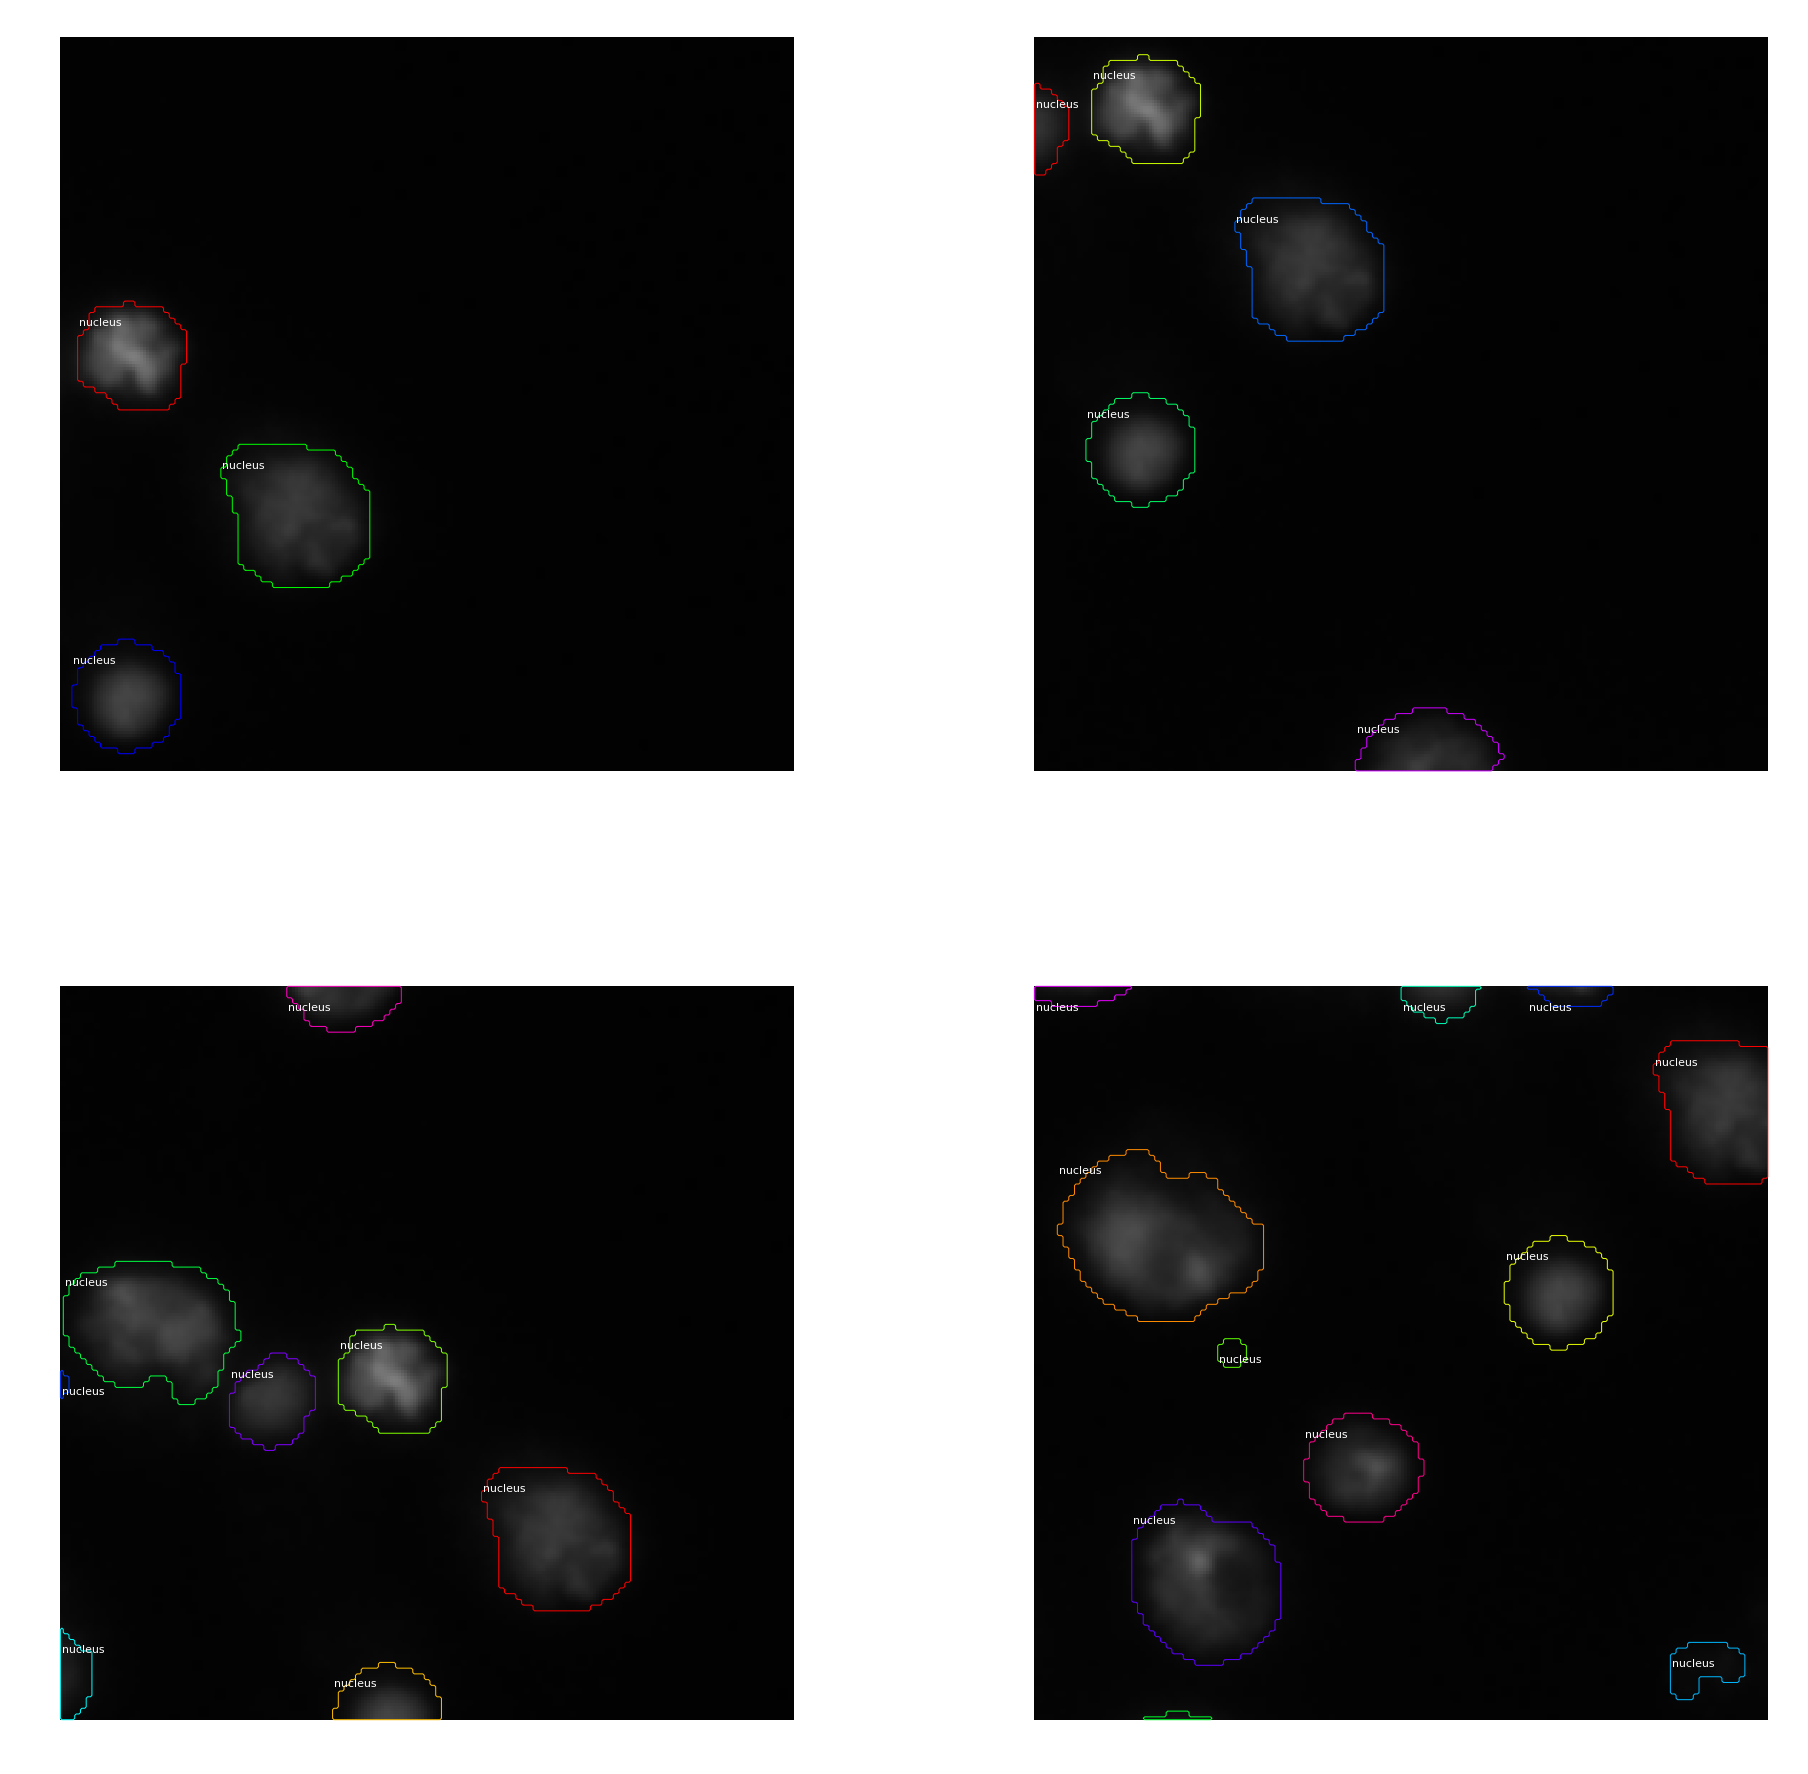

In [178]:
def get_ax(rows=1, cols=1, size=16):
    """Matplotlib Axes配列を返し、ノートブック内のすべての視覚化で使用されます。 
    グラフサイズを制御する中心点を提供します。
    
   サイズ属性を調整してイメージのレンダリングの程度を制御する
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

class RandomCropConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
crop_config = RandomCropConfig()
# 同じ画像を４回読み込んで拡大表示する
limit = 4
image_id = np.random.choice(dataset.image_ids, 1)[0]
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, crop_config, image_id, use_mini_mask=False)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

## Mini Masks

マスクを56×56ピクセルの大きさにリサイズして、背景がなるべく入らないように核１個を拡大する。これによりデータ量を最適化でき、学習のスピードをあげることができる。核の位置情報はbbox内に格納される。

image                    shape: (256, 256, 3)         min:    9.00000  max:  225.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int64
class_ids                shape: (6,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (6, 4)                min:    8.00000  max:  212.00000  int32
mask                     shape: (256, 256, 6)         min:    0.00000  max:    1.00000  bool


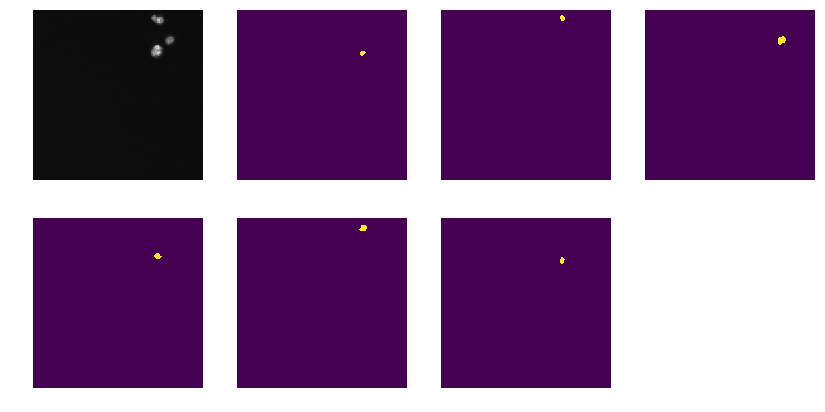

In [216]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

mask                     shape: (56, 56, 6)           min:    0.00000  max:    1.00000  bool


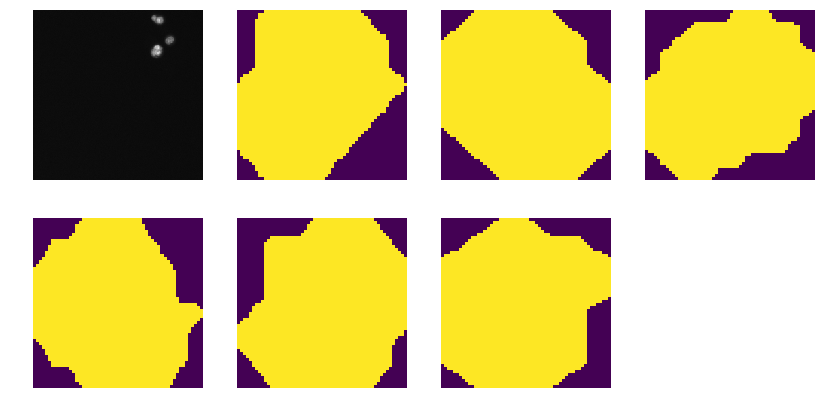

In [217]:
# 増補とマスクのサイズ変更を追加
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

# Augmentations

Augmentation(データの水増し)にはいろいろな手法があるが、
今回はGaussian Noiseを使ってデータを倍に増やした。

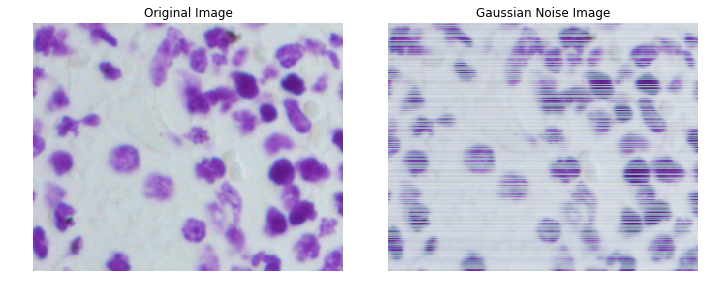

In [124]:
from imgaug import augmenters as iaa

im_path = training_sorted[3]
im = imageio.imread(str(im_path))
    
seq = iaa.Sequential([
#     iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    # iaa.Fliplr(0.2), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 2.0)) # blur images with a sigma of 0 to 3.0
])

images_aug = seq.augment_images(im)
#train_on_images(images_aug)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(images_aug)
plt.axis('off')
plt.title('Gaussian Noise Image')


plt.tight_layout()
plt.show()

上記のようなノイズを入れた画像を訓練データとして増やす。
下記コマンドでデータを複製し、複製したものにノイズを加えていく。

In [89]:
# Glob the training data and load a single image path
training_paths = pathlib.Path('../input_aug/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])

In [125]:
import shutil

# Augumentationの処理を記載
seq = iaa.Sequential([
    #iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    # iaa.Fliplr(0.2), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 1.0)) # blur images with a sigma of 0 to 3.0
])

BASE_DIR = "../input_aug/stage1_train/"

for img_path in training_sorted[1:]:
    #print(img_path)
#     print(type(img_path))
#     print(str(img_path).split('/')[:4])
#     str(img_path).split('/')[:4]
#     print(str(img_path).split('/')[5])
    img = imageio.imread(str(img_path))
    img_aug = seq.augment_images(img)

    imageio.imwrite(str(img_path), img_aug)

In [88]:
for img_path in training_sorted[1:]:
    img_path

通常の訓練データと水増ししたものを加えた訓練データのそれぞれのスコアは以下の通りです。

 Augmentation画像追加したデータで学習した場合の評価関数のスコアが向上しています。
### 通常のtrainデータ
val_mean_iou: 0.7935

### Augmentation画像追加したデータ

val_mean_iou: 0.8228

# UNET

### Unetの論文の要約は以下のURLから  

https://github.com/tatsuyaokunaga/Nuclei-Segmentation/blob/master/Unet-MaskRCNN-paper.ipynb

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

## UNet実装  (keras)

In [25]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [26]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [27]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:16<00:00,  8.77it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 85.51it/s]

Done!


/Users/okunagatatsuya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/okunagatatsuya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


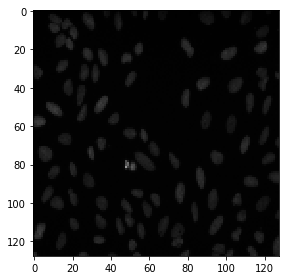

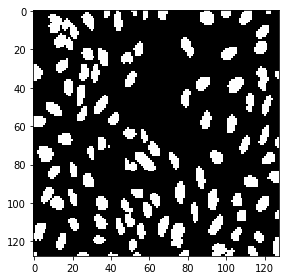

In [28]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [29]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

compile(self, optimizer, loss, metrics=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)

In [90]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
#model.summary()

In [32]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/30
603/603 [==============================] - 40s 66ms/step - loss: 0.4850 - mean_iou: 0.4200 - val_loss: 0.3462 - val_mean_iou: 0.4236

Epoch 00001: val_loss improved from inf to 0.34616, saving model to model-dsbowl2018-1.h5
Epoch 2/30
603/603 [==============================] - 38s 63ms/step - loss: 0.3027 - mean_iou: 0.4231 - val_loss: 0.2496 - val_mean_iou: 0.4236

Epoch 00002: val_loss improved from 0.34616 to 0.24964, saving model to model-dsbowl2018-1.h5
Epoch 3/30
603/603 [==============================] - 36s 60ms/step - loss: 0.2026 - mean_iou: 0.4314 - val_loss: 0.1512 - val_mean_iou: 0.4575

Epoch 00003: val_loss improved from 0.24964 to 0.15124, saving model to model-dsbowl2018-1.h5
Epoch 4/30
603/603 [==============================] - 37s 62ms/step - loss: 0.1471 - mean_iou: 0.4934 - val_loss: 0.1498 - val_mean_iou: 0.5245

Epoch 00004: val_loss improved from 0.15124 to 0.14978, saving model to model-dsbowl2018-1.h5
Epo

In [33]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 1s 19ms/step


In [ ]:
binary_accuracy(y_true, y_pred)

/Users/okunagatatsuya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/okunagatatsuya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


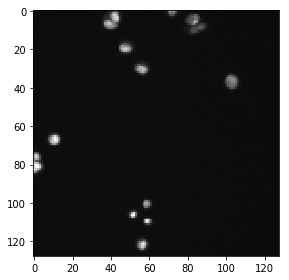

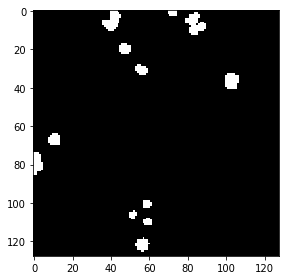

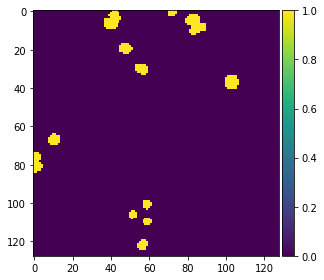

In [64]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

/Users/okunagatatsuya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/okunagatatsuya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


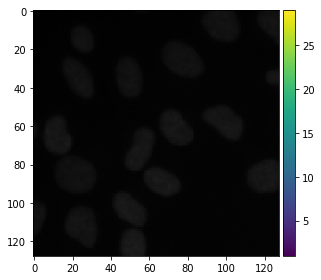

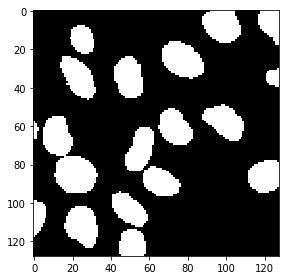

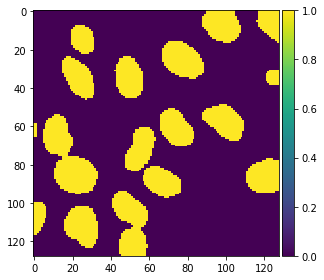

In [35]:
# いくつかのランダムなバリデーションサンプルでサニティチェックを実行する
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [36]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [37]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [38]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

# 転移学習

>「転移学習：機械学習の次のフロンティアへの招待」https://qiita.com/icoxfog417/items/48cbf087dd22f1f8c6f4#%E5%AD%A6%E7%BF%92%E6%B8%88%E3%81%BF%E3%83%A2%E3%83%87%E3%83%ABpre-trained-model%E3%81%AE%E9%81%A9%E5%BF%9C

>「Kerasで学ぶ転移学習」https://elix-tech.github.io/ja/2016/06/22/transfer-learning-ja.html

## 転移学習とファインチューニングとの違い
- 転移学習：既存の学習済モデル（出力層以外の部分）を、重みデータは変更せずに特徴量抽出機として利用する。
- ファインチューニング：既存の学習済モデル（出力層以外の部分）を、重みデータを一部再学習して特徴量抽出機として利用する。

## 転移学習についての各記事の抜粋

- ある領域で学習させたモデルを、別の領域に適応させる技術です。具体的には、広くデータが手に入る領域で学習させたモデルを少ないデータしかない領域に適応させたり、シミュレーター環境で学習させたモデルを現実に適応させたりする技術です。<b>「転移学習：機械学習の次のフロンティアへの招待」より</b>

- 畳み込みニューラルネットワーク（convolutional neural network, CNN）をまっさらな状態から学習させることは、実際にはあまりありません。学習に使えるデータの量が限られていたり、学習に時間がかかったりするためです。  
 120万枚・1000クラスからなるImageNetを使って学習させると数週間ほどかかったりしますが、学習済みの重みが公開されています。そこでこの重みをうまく使うことによって、効率よく学習を行うことを考えます。主に以下の方法が考えられます。  
  一つは、CNNを特徴抽出器として利用する方法です。最後の全結合層を取り除き、その他の部分を特徴抽出器として扱います。例えば、AlexNetでこれを行うと、それぞれの画像に対して4096次元のベクトルが得られます。この特徴量を保存しておき、今度はこれを入力としてソフトマックスなどの分類器を学習させます。新しく付けた層だけを学習させ、それ以外の層をフリーズさせておくこともできますが、これだと毎回特徴を抽出し直すことになってしまうため、余計に計算時間がかかってしまいます。  
  他には、畳み込み層を学習し直す方法もあります。学習済みの重みの値を初期値として、ニューラルネットワーク全体で学習し直すことができます。ランダムに初期化した場合よりもより早く学習が収束することが期待できます。  
   また、一部の層をフリーズさせておき、それ以外の層だけを学習し直す方法もあります。  
  <b>「Kerasで学ぶ転移学習」より</b>

# Mask R-CNN
## 実装
AWS上でMask-RCNNを実装し、学習を下記の通り実行しました。
上記の通り、Unetのval_loss値は0.0716。一方、Mask R-CNNのheadレイヤーとfullレイヤーの計40エポック中32エポック段階でのval_loss値は1.0を下らない結果でした。よってlossの精度ではUnetに軍配が上がります。

(tensorflow_p36) ubuntu@ip-172-31-34-52:~/Mask_RCNN/datasets/nucleus$ python3 nucleus.py train --dataset=./ --subset=train --weights=imagenet
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Weights:  imagenet
Dataset:  ./
Subset:  train
Logs:  /home/ubuntu/Mask_RCNN/logs

Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 6
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               200
MEAN_PIXEL                     [43.53 39.56 48.22]
MINI_MASK_SHAPE                (56, 56)
NAME                           nucleus
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        2000
POST_NMS_ROIS_TRAINING         1000
ROI_POSITIVE_RATIO             0.33
RPN_ANCHOR_RATIOS              [0.5, 1, 2]
RPN_ANCHOR_SCALES              (8, 16, 32, 64, 128)
RPN_ANCHOR_STRIDE              1
RPN_BBOX_STD_DEV               [0.1 0.1 0.2 0.2]
RPN_NMS_THRESHOLD              0.9
RPN_TRAIN_ANCHORS_PER_IMAGE    64
STEPS_PER_EPOCH                105
TOP_DOWN_PYRAMID_SIZE          256
TRAIN_BN                       False
TRAIN_ROIS_PER_IMAGE           128
USE_MINI_MASK                  True
USE_RPN_ROIS                   True
VALIDATION_STEPS               4
WEIGHT_DECAY                   0.0001


Loading weights  /home/ubuntu/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
2018-06-16 09:49:08.929784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-06-16 09:49:08.930237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-06-16 09:49:08.930275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1435] Adding visible gpu devices: 0
2018-06-16 09:49:09.225094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:923] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-06-16 09:49:09.225157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:929]      0 
2018-06-16 09:49:09.225173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:942] 0:   N 
2018-06-16 09:49:09.225500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1053] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10763 MB memory) -> physical GPU (device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7)
./stage1_train
Train network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/Mask_RCNN/logs/nucleus20180616T0949/mask_rcnn_nucleus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrcnn_class_logits     (TimeDistributed)
mrcnn_mask             (TimeDistributed)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
Epoch 1/20
104/105 [============================>.] - ETA: 3s - loss: 2.7272 - rpn_class_loss: 0.3164 - rpn_bbox_loss: 1.0433 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.5202 - mrcnn_mask_loss: 0.6291/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
105/105 [==============================] - 435s 4s/step - loss: 2.7223 - rpn_class_loss: 0.3150 - rpn_bbox_loss: 1.0412 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.5192 - mrcnn_mask_loss: 0.6288 - val_loss: 2.2430 - val_rpn_class_loss: 0.1880 - val_rpn_bbox_loss: 0.8546 - val_mrcnn_class_loss: 0.2013 - val_mrcnn_bbox_loss: 0.3956 - val_mrcnn_mask_loss: 0.6035
Epoch 2/20
105/105 [==============================] - 492s 5s/step - loss: 2.0557 - rpn_class_loss: 0.1564 - rpn_bbox_loss: 0.7725 - mrcnn_class_loss: 0.2237 - mrcnn_bbox_loss: 0.3458 - mrcnn_mask_loss: 0.5574 - val_loss: 2.2141 - val_rpn_class_loss: 0.1790 - val_rpn_bbox_loss: 0.7952 - val_mrcnn_class_loss: 0.2797 - val_mrcnn_bbox_loss: 0.4023 - val_mrcnn_mask_loss: 0.5579
Epoch 3/20
105/105 [==============================] - 380s 4s/step - loss: 1.7891 - rpn_class_loss: 0.1218 - rpn_bbox_loss: 0.6843 - mrcnn_class_loss: 0.2227 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 0.4699 - val_loss: 1.9768 - val_rpn_class_loss: 0.1656 - val_rpn_bbox_loss: 0.7125 - val_mrcnn_class_loss: 0.2767 - val_mrcnn_bbox_loss: 0.3521 - val_mrcnn_mask_loss: 0.4698
Epoch 4/20
105/105 [==============================] - 379s 4s/step - loss: 1.6469 - rpn_class_loss: 0.1062 - rpn_bbox_loss: 0.6308 - mrcnn_class_loss: 0.2250 - mrcnn_bbox_loss: 0.2849 - mrcnn_mask_loss: 0.3999 - val_loss: 1.8441 - val_rpn_class_loss: 0.1294 - val_rpn_bbox_loss: 0.7312 - val_mrcnn_class_loss: 0.2015 - val_mrcnn_bbox_loss: 0.3444 - val_mrcnn_mask_loss: 0.4376
Epoch 5/20
105/105 [==============================] - 366s 3s/step - loss: 1.5358 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 0.5751 - mrcnn_class_loss: 0.2251 - mrcnn_bbox_loss: 0.2685 - mrcnn_mask_loss: 0.3669 - val_loss: 1.7451 - val_rpn_class_loss: 0.1104 - val_rpn_bbox_loss: 0.6423 - val_mrcnn_class_loss: 0.2373 - val_mrcnn_bbox_loss: 0.3403 - val_mrcnn_mask_loss: 0.4149
Epoch 6/20
105/105 [==============================] - 360s 3s/step - loss: 1.4002 - rpn_class_loss: 0.0845 - rpn_bbox_loss: 0.5297 - mrcnn_class_loss: 0.2233 - mrcnn_bbox_loss: 0.2336 - mrcnn_mask_loss: 0.3290 - val_loss: 1.7508 - val_rpn_class_loss: 0.1075 - val_rpn_bbox_loss: 0.6459 - val_mrcnn_class_loss: 0.2747 - val_mrcnn_bbox_loss: 0.3261 - val_mrcnn_mask_loss: 0.3966
Epoch 7/20
105/105 [==============================] - 377s 4s/step - loss: 1.3734 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 0.5111 - mrcnn_class_loss: 0.2291 - mrcnn_bbox_loss: 0.2303 - mrcnn_mask_loss: 0.3217 - val_loss: 1.7639 - val_rpn_class_loss: 0.0936 - val_rpn_bbox_loss: 0.6809 - val_mrcnn_class_loss: 0.2427 - val_mrcnn_bbox_loss: 0.3387 - val_mrcnn_mask_loss: 0.4079
Epoch 8/20
105/105 [==============================] - 398s 4s/step - loss: 1.3098 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 0.4921 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3050 - val_loss: 1.5663 - val_rpn_class_loss: 0.1121 - val_rpn_bbox_loss: 0.5763 - val_mrcnn_class_loss: 0.2508 - val_mrcnn_bbox_loss: 0.2687 - val_mrcnn_mask_loss: 0.3584
Epoch 9/20
105/105 [==============================] - 410s 4s/step - loss: 1.3099 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 0.4827 - mrcnn_class_loss: 0.2270 - mrcnn_bbox_loss: 0.2203 - mrcnn_mask_loss: 0.3069 - val_loss: 1.7037 - val_rpn_class_loss: 0.0993 - val_rpn_bbox_loss: 0.6092 - val_mrcnn_class_loss: 0.2807 - val_mrcnn_bbox_loss: 0.3270 - val_mrcnn_mask_loss: 0.3876
Epoch 10/20
105/105 [==============================] - 420s 4s/step - loss: 1.2722 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 0.4533 - mrcnn_class_loss: 0.2274 - mrcnn_bbox_loss: 0.2170 - mrcnn_mask_loss: 0.3071 - val_loss: 1.5262 - val_rpn_class_loss: 0.0804 - val_rpn_bbox_loss: 0.5581 - val_mrcnn_class_loss: 0.2562 - val_mrcnn_bbox_loss: 0.2806 - val_mrcnn_mask_loss: 0.3509
Epoch 11/20
105/105 [==============================] - 367s 3s/step - loss: 1.1897 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.4284 - mrcnn_class_loss: 0.2163 - mrcnn_bbox_loss: 0.1974 - mrcnn_mask_loss: 0.2869 - val_loss: 1.5383 - val_rpn_class_loss: 0.1147 - val_rpn_bbox_loss: 0.5422 - val_mrcnn_class_loss: 0.2572 - val_mrcnn_bbox_loss: 0.2712 - val_mrcnn_mask_loss: 0.3530
Epoch 12/20
105/105 [==============================] - 332s 3s/step - loss: 1.2015 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 0.4282 - mrcnn_class_loss: 0.2230 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.2829 - val_loss: 1.3940 - val_rpn_class_loss: 0.0731 - val_rpn_bbox_loss: 0.5278 - val_mrcnn_class_loss: 0.2316 - val_mrcnn_bbox_loss: 0.2424 - val_mrcnn_mask_loss: 0.3191
Epoch 13/20
105/105 [==============================] - 400s 4s/step - loss: 1.1795 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 0.4121 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1968 - mrcnn_mask_loss: 0.2866 - val_loss: 1.4891 - val_rpn_class_loss: 0.0848 - val_rpn_bbox_loss: 0.4957 - val_mrcnn_class_loss: 0.2913 - val_mrcnn_bbox_loss: 0.2704 - val_mrcnn_mask_loss: 0.3468
Epoch 14/20
105/105 [==============================] - 443s 4s/step - loss: 1.1344 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 0.3924 - mrcnn_class_loss: 0.2159 - mrcnn_bbox_loss: 0.1900 - mrcnn_mask_loss: 0.2782 - val_loss: 1.4202 - val_rpn_class_loss: 0.0570 - val_rpn_bbox_loss: 0.5339 - val_mrcnn_class_loss: 0.2354 - val_mrcnn_bbox_loss: 0.2760 - val_mrcnn_mask_loss: 0.3179
Epoch 15/20
105/105 [==============================] - 328s 3s/step - loss: 1.1424 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 0.3906 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1924 - mrcnn_mask_loss: 0.2862 - val_loss: 1.2981 - val_rpn_class_loss: 0.0490 - val_rpn_bbox_loss: 0.4942 - val_mrcnn_class_loss: 0.1899 - val_mrcnn_bbox_loss: 0.2589 - val_mrcnn_mask_loss: 0.3062
Epoch 16/20
105/105 [==============================] - 433s 4s/step - loss: 1.1135 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 0.3834 - mrcnn_class_loss: 0.2143 - mrcnn_bbox_loss: 0.1853 - mrcnn_mask_loss: 0.2731 - val_loss: 1.3532 - val_rpn_class_loss: 0.0521 - val_rpn_bbox_loss: 0.5004 - val_mrcnn_class_loss: 0.2290 - val_mrcnn_bbox_loss: 0.2424 - val_mrcnn_mask_loss: 0.3293
Epoch 17/20
105/105 [==============================] - 363s 3s/step - loss: 1.1032 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.3783 - mrcnn_class_loss: 0.2092 - mrcnn_bbox_loss: 0.1841 - mrcnn_mask_loss: 0.2724 - val_loss: 1.5914 - val_rpn_class_loss: 0.0880 - val_rpn_bbox_loss: 0.5606 - val_mrcnn_class_loss: 0.2779 - val_mrcnn_bbox_loss: 0.2959 - val_mrcnn_mask_loss: 0.3690
Epoch 18/20
105/105 [==============================] - 426s 4s/step - loss: 1.0946 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 0.3752 - mrcnn_class_loss: 0.2105 - mrcnn_bbox_loss: 0.1838 - mrcnn_mask_loss: 0.2729 - val_loss: 1.3919 - val_rpn_class_loss: 0.0714 - val_rpn_bbox_loss: 0.4745 - val_mrcnn_class_loss: 0.2460 - val_mrcnn_bbox_loss: 0.2678 - val_mrcnn_mask_loss: 0.3322
Epoch 19/20
105/105 [==============================] - 347s 3s/step - loss: 1.0904 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 0.3599 - mrcnn_class_loss: 0.2148 - mrcnn_bbox_loss: 0.1856 - mrcnn_mask_loss: 0.2762 - val_loss: 1.2522 - val_rpn_class_loss: 0.0677 - val_rpn_bbox_loss: 0.4683 - val_mrcnn_class_loss: 0.2253 - val_mrcnn_bbox_loss: 0.2100 - val_mrcnn_mask_loss: 0.2809
Epoch 20/20
105/105 [==============================] - 358s 3s/step - loss: 1.0283 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.3484 - mrcnn_class_loss: 0.2019 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.2616 - val_loss: 1.3205 - val_rpn_class_loss: 0.0525 - val_rpn_bbox_loss: 0.4719 - val_mrcnn_class_loss: 0.2266 - val_mrcnn_bbox_loss: 0.2572 - val_mrcnn_mask_loss: 0.3124
Train all layers

Starting at epoch 20. LR=0.001

Checkpoint Path: /home/ubuntu/Mask_RCNN/logs/nucleus20180616T0949/mask_rcnn_nucleus_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm)
res3a_branch2c         (Conv2D)
res3a_branch1          (Conv2D)
bn3a_branch2c          (BatchNorm)
bn3a_branch1           (BatchNorm)
res3b_branch2a         (Conv2D)
bn3b_branch2a          (BatchNorm)
res3b_branch2b         (Conv2D)
bn3b_branch2b          (BatchNorm)
res3b_branch2c         (Conv2D)
bn3b_branch2c          (BatchNorm)
res3c_branch2a         (Conv2D)
bn3c_branch2a          (BatchNorm)
res3c_branch2b         (Conv2D)
bn3c_branch2b          (BatchNorm)
res3c_branch2c         (Conv2D)
bn3c_branch2c          (BatchNorm)
res3d_branch2a         (Conv2D)
bn3d_branch2a          (BatchNorm)
res3d_branch2b         (Conv2D)
bn3d_branch2b          (BatchNorm)
res3d_branch2c         (Conv2D)
bn3d_branch2c          (BatchNorm)
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_branch2c         (Conv2D)
bn4d_branch2c          (BatchNorm)
res4e_branch2a         (Conv2D)
bn4e_branch2a          (BatchNorm)
res4e_branch2b         (Conv2D)
bn4e_branch2b          (BatchNorm)
res4e_branch2c         (Conv2D)
bn4e_branch2c          (BatchNorm)
res4f_branch2a         (Conv2D)
bn4f_branch2a          (BatchNorm)
res4f_branch2b         (Conv2D)
bn4f_branch2b          (BatchNorm)
res4f_branch2c         (Conv2D)
bn4f_branch2c          (BatchNorm)
res5a_branch2a         (Conv2D)
bn5a_branch2a          (BatchNorm)
res5a_branch2b         (Conv2D)
bn5a_branch2b          (BatchNorm)
res5a_branch2c         (Conv2D)
res5a_branch1          (Conv2D)
bn5a_branch2c          (BatchNorm)
bn5a_branch1           (BatchNorm)
res5b_branch2a         (Conv2D)
bn5b_branch2a          (BatchNorm)
res5b_branch2b         (Conv2D)
bn5b_branch2b          (BatchNorm)
res5b_branch2c         (Conv2D)
bn5b_branch2c          (BatchNorm)
res5c_branch2a         (Conv2D)
bn5c_branch2a          (BatchNorm)
res5c_branch2b         (Conv2D)
bn5c_branch2b          (BatchNorm)
res5c_branch2c         (Conv2D)
bn5c_branch2c          (BatchNorm)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrcnn_class_logits     (TimeDistributed)
mrcnn_mask             (TimeDistributed)
Epoch 21/40
105/105 [==============================] - 443s 4s/step - loss: 1.0329 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.3454 - mrcnn_class_loss: 0.2060 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.2635 - val_loss: 1.5055 - val_rpn_class_loss: 0.0627 - val_rpn_bbox_loss: 0.5129 - val_mrcnn_class_loss: 0.3133 - val_mrcnn_bbox_loss: 0.2712 - val_mrcnn_mask_loss: 0.3455
Epoch 22/40
 79/105 [=====================>........] - ETA: 1:18 - loss: 1.0076 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.3242 - mrcnn_class_loss: 0.2114 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.25852018-06-16 12:12:40.425187: W tensorflow/core/common_runtime/bfc_allocator.cc:219] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2018-06-16 12:12:40.425324: W tensorflow/stream_executor/cuda/cuda_dnn.cc:3526] 
105/105 [==============================] - 389s 4s/step - loss: 0.9970 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.3201 - mrcnn_class_loss: 0.2096 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.2555 - val_loss: 1.2536 - val_rpn_class_loss: 0.0527 - val_rpn_bbox_loss: 0.4099 - val_mrcnn_class_loss: 0.2571 - val_mrcnn_bbox_loss: 0.2301 - val_mrcnn_mask_loss: 0.3037
Epoch 23/40
105/105 [==============================] - 398s 4s/step - loss: 0.9783 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.3055 - mrcnn_class_loss: 0.2059 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.2591 - val_loss: 1.2385 - val_rpn_class_loss: 0.0590 - val_rpn_bbox_loss: 0.3666 - val_mrcnn_class_loss: 0.2741 - val_mrcnn_bbox_loss: 0.2236 - val_mrcnn_mask_loss: 0.3152
Epoch 24/40
105/105 [==============================] - 365s 3s/step - loss: 0.9494 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.2916 - mrcnn_class_loss: 0.2039 - mrcnn_bbox_loss: 0.1577 - mrcnn_mask_loss: 0.2538 - val_loss: 1.1845 - val_rpn_class_loss: 0.0611 - val_rpn_bbox_loss: 0.3583 - val_mrcnn_class_loss: 0.2560 - val_mrcnn_bbox_loss: 0.2167 - val_mrcnn_mask_loss: 0.2924
Epoch 25/40
105/105 [==============================] - 417s 4s/step - loss: 0.9335 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.2833 - mrcnn_class_loss: 0.2010 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.2531 - val_loss: 1.2804 - val_rpn_class_loss: 0.0468 - val_rpn_bbox_loss: 0.4254 - val_mrcnn_class_loss: 0.2818 - val_mrcnn_bbox_loss: 0.2227 - val_mrcnn_mask_loss: 0.3037
Epoch 26/40
105/105 [==============================] - 414s 4s/step - loss: 0.9125 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.2745 - mrcnn_class_loss: 0.1999 - mrcnn_bbox_loss: 0.1538 - mrcnn_mask_loss: 0.2462 - val_loss: 1.0997 - val_rpn_class_loss: 0.0337 - val_rpn_bbox_loss: 0.3344 - val_mrcnn_class_loss: 0.2323 - val_mrcnn_bbox_loss: 0.2158 - val_mrcnn_mask_loss: 0.2835
Epoch 27/40
105/105 [==============================] - 367s 3s/step - loss: 0.8892 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.2551 - mrcnn_class_loss: 0.1940 - mrcnn_bbox_loss: 0.1528 - mrcnn_mask_loss: 0.2511 - val_loss: 1.1274 - val_rpn_class_loss: 0.0363 - val_rpn_bbox_loss: 0.3804 - val_mrcnn_class_loss: 0.2386 - val_mrcnn_bbox_loss: 0.1998 - val_mrcnn_mask_loss: 0.2722
Epoch 28/40
 50/105 [=============>................] - ETA: 2:46 - loss: 0.8626 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.2475 - mrcnn_class_loss: 0.1887 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.24612018-06-16 12:50:29.188943: W tensorflow/core/common_runtime/bfc_allocator.cc:219] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2018-06-16 12:50:29.189042: W tensorflow/stream_executor/cuda/cuda_dnn.cc:3526] 
105/105 [==============================] - 379s 4s/step - loss: 0.8666 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.2506 - mrcnn_class_loss: 0.1895 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.2454 - val_loss: 1.0593 - val_rpn_class_loss: 0.0362 - val_rpn_bbox_loss: 0.3369 - val_mrcnn_class_loss: 0.2411 - val_mrcnn_bbox_loss: 0.1785 - val_mrcnn_mask_loss: 0.2667
Epoch 29/40
105/105 [==============================] - 374s 4s/step - loss: 0.8846 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.2591 - mrcnn_class_loss: 0.1911 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2483 - val_loss: 1.1864 - val_rpn_class_loss: 0.0363 - val_rpn_bbox_loss: 0.3219 - val_mrcnn_class_loss: 0.2734 - val_mrcnn_bbox_loss: 0.2215 - val_mrcnn_mask_loss: 0.3333
Epoch 30/40
105/105 [==============================] - 390s 4s/step - loss: 0.8530 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.2422 - mrcnn_class_loss: 0.1902 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2424 - val_loss: 1.1808 - val_rpn_class_loss: 0.0522 - val_rpn_bbox_loss: 0.3450 - val_mrcnn_class_loss: 0.2678 - val_mrcnn_bbox_loss: 0.2211 - val_mrcnn_mask_loss: 0.2947
Epoch 31/40
105/105 [==============================] - 367s 3s/step - loss: 0.8667 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.2454 - mrcnn_class_loss: 0.1935 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.2467 - val_loss: 1.1888 - val_rpn_class_loss: 0.0644 - val_rpn_bbox_loss: 0.3730 - val_mrcnn_class_loss: 0.2559 - val_mrcnn_bbox_loss: 0.2101 - val_mrcnn_mask_loss: 0.2853
Epoch 32/40

# ハイパーパラメータチューニング

### UNETのクラス化

In [218]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
import tensorflow as tf
from keras import optimizers

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'


seed = 42
random.seed = seed
np.random.seed = seed

In [219]:
class UNET():
    def __init__(self,IMG_WIDTH = 128,IMG_HEIGHT = 128,
                 IMG_CHANNELS = 3,
                 TRAIN_PATH = '../input/stage1_train/', 
                 TEST_PATH = '../input/stage1_test/' ,
                 train_ids = next(os.walk(TRAIN_PATH))[1],
                 test_ids = next(os.walk(TEST_PATH))[1],
                 
                 validation_split=0.1,
                 batch_size=8, 
                 epochs=10, verbose=1):
        seed = 42
        random.seed = seed
        np.random.seed = seed
        self.IMG_WIDTH = IMG_WIDTH 
        self.IMG_HEIGHT=IMG_HEIGHT
        self.IMG_CHANNELS = IMG_CHANNELS
        self.TRAIN_PATH = TRAIN_PATH
        self.TEST_PATH = TEST_PATH
        self.validation_split=validation_split
        self.batch_size= batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.train_ids = train_ids
        self.test_ids = test_ids

In [220]:
# Get train and test IDs
# train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]

In [221]:
# Get and resize train images and masks
def unet_data(self):
    X_train = np.zeros((len(self.train_ids), self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(self.train_ids), self.IMG_HEIGHT, self.IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(self.train_ids), total=len(self.train_ids)):
        path = self.TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:self.IMG_CHANNELS]
        img = resize(img, (self.IMG_HEIGHT, self.IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((self.IMG_HEIGHT, awlf.IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (self.IMG_HEIGHT, self.IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask

    # Get and resize test images
    X_test = np.zeros((len(self.test_ids), self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('Getting and resizing test images ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(self.test_ids), total=len(self.test_ids)):
        path = self.TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:self.IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (self.IMG_HEIGHT,self.IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img

    print('Done!')
    return  X_train,Y_train,X_test

In [222]:
# IoU metric を定義
def mean_iou(self,y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [223]:
# U-Net model　構築
def unet_model(self):
    inputs = Input((self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model


#     model.compile(optimizer=key, loss='binary_crossentropy', metrics=[mean_iou])
#     #model.summary()
#     # Fit model
#     earlystopper = EarlyStopping(patience=3, verbose=0)
#     checkpointer = ModelCheckpoint('model-dsbowl2018-1'+key+'.h5', verbose=1, save_best_only=True)
#     results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=10, verbose=1,
#                         callbacks=[earlystopper, checkpointer])

## optimierのチューニング

In [226]:
params={}

params['sgd'] = optimizers.SGD(lr=0.01, clipvalue=0.5)
params['Adam'] =optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['RMSprop'] = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
params['Adagrad'] = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
params['Adadelta'] = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
params['Nadam'] = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
for key in params:
    X_train, Y_train
    model.compile(optimizer=key, loss='binary_crossentropy', metrics=[mean_iou])
    #model.summary()
    # Fit model
    earlystopper = EarlyStopping(patience=3, verbose=0)
    checkpointer = ModelCheckpoint('model-dsbowl2018-1'+key+'.h5', verbose=1, save_best_only=True)
    results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=10, verbose=1,
                        callbacks=[earlystopper, checkpointer])

### 以上の学習から各optimizerのlossと評価関数の値は下記の通り。

- SGD : val_loss  0.21166  val_mean_iou: 0.4693  
- Adam : val_loss  0.07101 val_mean_iou: 0.8139  
- Adagrad : val_loss 0.06724 val_mean_iou: 0.8648  
- Adadelta : val_loss 0.06985 val_mean_iou: 0.8804  
- Nadam : val_loss 0.06679  val_mean_iou: 0.8867  

### Nadamが精度ではトップ
